In [1]:
#importando os modulos
import sys
sys.path.append('euthyroid_sick_syndrome')
from utils import *
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
import numpy as np
from sklearn.model_selection import GridSearchCV


In [2]:
#Carregando o dataset
dataset = pd.read_csv('/home/vinicius/UFERSA/cilab/euthyroid_sick_syndrome/euthyroid_sick_syndrome/datasets/euthyroid/euthyroid_final_features.csv')
output_label_dataset = dataset['classification']
dataset = dataset.drop(['classification'], axis=1)

#Balanceando dos dados 
dataset_res, ouput_label = balance_dataset_smote(dataset, output_label_dataset, random_state=42, k_neighbors=5)

#Dividindo o dataset em treino e teste
#80 % para treino e 20% para teste
input_train, input_test, output_train, output_test = slipt_and_standardize_dataset(dataset=dataset_res, output_label=ouput_label)

## RFE Recursive feature elimination

['Age', 'TSH', 'T3', 'T4U', 'FTI']

A acurácia é de:  0.985191637630662
['Age', 'OT', 'QH', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

A acurácia é de:  0.9790940766550522


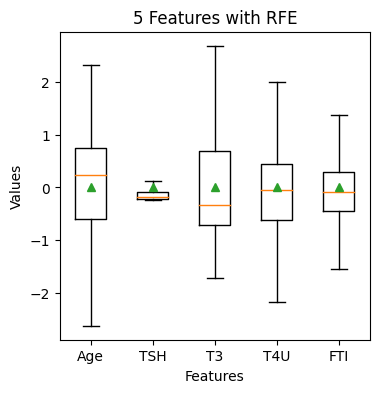

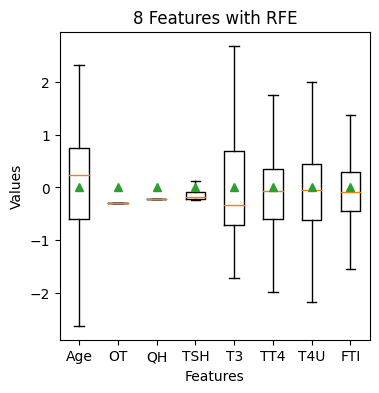

In [18]:


#Selecionando features Usando RFE (Recursive feature elimination)

model = RandomForestClassifier(bootstrap=False, criterion='log_loss', max_depth=26,
max_features='sqrt', min_samples_split=40, n_estimators=100)
model.fit(input_train, output_train)
'''
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False],
        'max_depth': np.arange(10, 30, 5),
        'n_estimators': [10, 30, 50, 100],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]}

model = GridSearchCV(estimator = model, param_grid = param_grid)
model.fit(input_train, output_train)
print(model.best_params_)
'''


# Definir o RFE com 3 recursos a serem selecionados, ou seja ele está selecionando as 3 melhores features
for j in [5, 8]:
 
 rfe = RFE(estimator=model, n_features_to_select = j)

 # Executar o RFE no conjunto de treinamento
 rfe.fit(input_train, output_train)

 selected_feature_names = dataset.columns[rfe.support_]

 #substituindo o nome das features

 nomes = dataset.columns[rfe.support_]
 substituicoes = {
    'age': 'Age',
    'on_thyroxine': 'OT',
    'query_hypothyroid': 'QH'
 }

 

 def substituir_nomes(lista, substituicoes):
    return [substituicoes[nome] if nome in substituicoes else nome for nome in lista]

 selected_feature_names_ajust = substituir_nomes(nomes, substituicoes)

 print(selected_feature_names_ajust)


 # Selecionar os recursos do conjunto de treinamento e teste
 input_train_rfe = rfe.transform(input_train)
 X_test_rfe = rfe.transform(input_test)

 feature_values = [input_train_rfe[:, i] for i in range(input_train_rfe.shape[1])]

 # Criando um novo modelo com os recursos selecionados
 model.fit(input_train_rfe, output_train)

 # Avaliando a acuracia do modelo no conjunto de teste

 y_pred = model.predict(X_test_rfe)

 accuracy(output_test, y_pred)
 plt.figure(figsize=(4, 4))
 plt.boxplot(feature_values, labels=selected_feature_names_ajust, showmeans=True, showfliers=False)
 plt.title('{} Features with RFE'.format(j))
 plt.xlabel('Features')
 plt.ylabel('Values')
 plt.savefig('RFE_{}_english.png'.format(j), dpi=300, bbox_inches='tight')